In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.ticker as mticker
import scipy.stats as stats

In [2]:
crypto = pd.read_csv('CCI.csv', index_col='Date', parse_dates=True)
crypto.columns = ['Crypto']

stocks = pd.read_excel('SP500.xlsx', index_col='Date', parse_dates=True)
stocks.columns = ['Stocks']

commodity = pd.read_csv('BBG Commodity.csv', index_col='Date', parse_dates=True)
commodity.columns = ['Commodity']

fx = pd.read_excel('USD Index.xlsx', index_col='Date', parse_dates=True)
fx.columns = ['FX']

bond = pd.read_excel('US AGG.xlsx', index_col='Date', parse_dates=True)
bond.columns = ['Bond']

data = pd.concat([crypto, stocks, commodity, fx, bond], axis=1)
data = data.interpolate(method='time', axis=0)
data = data.dropna()

data = data.resample('W').last()

# data = data[data.index < '2018-08-15']

In [3]:
returns = np.log(data / data.shift(1)).dropna()

cumulative_returns = np.exp(returns.cumsum())
cumulative_returns.iloc[0] = 1

## Assets Profiles

In [4]:
freq = 52
rf = 0.0157 # The 3-month treasury bill rate has been used as proxy for the risk-free rate

### Avg, Std, Sharpe, MDD, Weeks to recovery

In [5]:
avg_return = np.exp(returns.mean()) - 1  # Weekly
avg_return = ((1 + avg_return) ** freq - 1)  # Yearly

std = returns.std() * np.sqrt(freq)

sharpe = (avg_return - rf) / std

dd = cumulative_returns / cumulative_returns.cummax() - 1 # Drawdown
mdd = dd.min()

recovery_list = {}
for column in dd.columns:
    asset_dd = dd[column]
    mdd_date = asset_dd.idxmin()
    mdd_peak_val = cumulative_returns[column].cummax().loc[mdd_date]
    mdd_after = cumulative_returns[column].loc[mdd_date:]
    recovered = mdd_after[mdd_after >= mdd_peak_val]
    if not recovered.empty:
        recovery_date = recovered.index[0]
        recovery_weeks = (recovery_date - mdd_date).days // 7
    else:
        recovery_weeks = None

    recovery_list[column] = recovery_weeks

recovery_list = pd.Series(recovery_list)

In [6]:
summary = pd.DataFrame({'Avg Return': avg_return, 'Std Dev': std, 'Sharpe': sharpe, 'MDD': mdd, 'Weeks to Recovery': recovery_list})
display(summary)

,Avg Return,Std Dev,Sharpe,MDD,Weeks to Recovery
Crypto,0.728150,0.769914,0.925363,-0.838379,105.0
Stocks,0.119457,0.155041,0.669221,-0.330443,21.0
Commodity,-0.019414,0.132591,-0.264830,-0.566487,NaN
FX,0.027899,0.050788,0.240186,-0.125770,68.0
Bond,0.013960,0.042737,-0.040708,-0.182968,NaN


## Asset Correlation

In [8]:
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

In [18]:
correlation = returns.corr()
p_values = returns.corr(method=lambda x, y: stats.pearsonr(x, y)[1])

significance = p_values.map(significance_stars)
combined_matrix = correlation.round(4).astype(str) + significance

print(combined_matrix)


              Crypto      Stocks   Commodity          FX        Bond
Crypto           1.0   0.1708***   0.1327***    -0.0763*       0.018
Stocks     0.1708***         1.0   0.3285***  -0.4688***   0.1784***
Commodity  0.1327***   0.3285***         1.0  -0.4029***     -0.0322
FX          -0.0763*  -0.4688***  -0.4029***         1.0  -0.3863***
Bond           0.018   0.1784***     -0.0322  -0.3863***         1.0


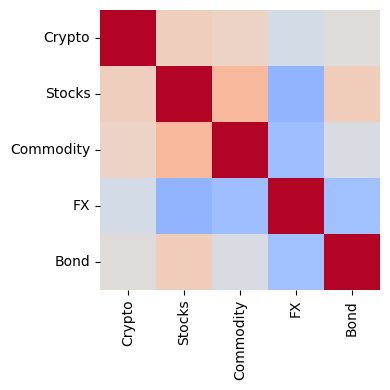

In [165]:
plt.figure(figsize=(4, 4))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, center=0, cbar=False, annot=False)
plt.tight_layout()
plt.show()

## Asset Allocation

In [166]:
def portfolio_variance(w, cov):
    return w @ cov @ w

def get_weights(mu, cov, target_mu=None):
    n = len(mu)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    if target_mu is not None:
        constraints.append({'type': 'eq', 'fun': lambda w: w @ mu - target_mu})
    bounds = [(0, None)] * n
    initial_weights = np.ones(n) / n
    result = minimize(portfolio_variance, initial_weights, args=(cov,), 
                      constraints=constraints, bounds=bounds)
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization did not converge")

def gmvp_weight(mu, cov):
    return get_weights(mu, cov)

def mvp_weight(mu, cov, target_mu):
    return get_weights(mu, cov, target_mu)

def tangency_portfolio(mu, cov, rf):
    excess_returns = mu - rf
    n = len(mu)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    
    bounds = [(0, None)] * n
    
    initial_weights = np.ones(n) / n
    
    def neg_sharpe_ratio(w):
        portfolio_return = np.dot(w, excess_returns)
        portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -portfolio_return / portfolio_volatility
    
    result = minimize(neg_sharpe_ratio, initial_weights, 
                      bounds=bounds, constraints=constraints)
    
    if not result.success:
        raise ValueError('Optimization did not coverage')
    
    weights = result.x

    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility

    summary = np.array([portfolio_return, portfolio_volatility, sharpe_ratio, *weights])
    return summary


### Including CCs

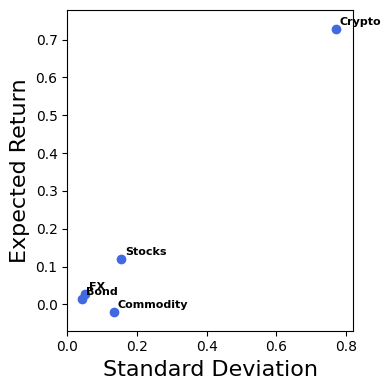

In [167]:
mu = avg_return.copy()
cov = returns.cov() * freq
std = np.sqrt(np.diag(cov))

plt.figure(figsize=(4, 4))
plt.scatter(std, mu, c='royalblue', label='Assets')
for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std.max() + 0.05)
plt.ylim(mu.min() - 0.05, mu.max() + 0.05)
plt.tight_layout()
plt.savefig('Asset Allocation_Individual Assets.png', dpi=144, transparent=True)
plt.show()

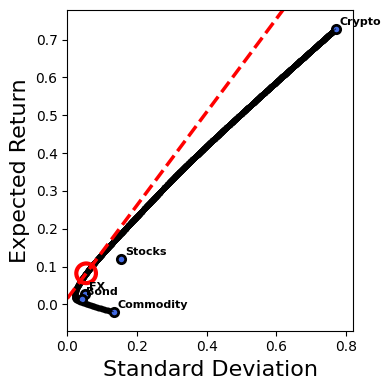

In [168]:
mu_targets = np.linspace(mu.min(), mu.max(), 1000)

portfolio_weights = [mvp_weight(mu, cov, target) for target in mu_targets]
portfolio_mu = [w @ mu for w in portfolio_weights]
portfolio_std = [np.sqrt(w @ cov @ w) for w in portfolio_weights]

# # GMVP
# gmvp = gmvp_weight(mu, cov)
# gmvp_mu = gmvp @ mu
# gmvp_std = np.sqrt(gmvp @ cov @ gmvp)

sharpe_ratios = (np.array(portfolio_mu) - rf) / np.array(portfolio_std)
max_sharpe_index = sharpe_ratios.argmax()
tangency_return = portfolio_mu[max_sharpe_index]
tangency_risk = portfolio_std[max_sharpe_index]

cal_x = np.linspace(0, max(portfolio_std), 100)
cal_x = np.linspace(0, 1, 1000)
cal_y = rf + sharpe_ratios[max_sharpe_index] * cal_x

plt.figure(figsize=(4, 4))

plt.scatter(portfolio_std, portfolio_mu, c='k', label='Efficient Frontier', s=10)
plt.plot(portfolio_std, portfolio_mu, color='k', linewidth=0.5)

# plt.scatter(gmvp_std, gmvp_mu, c='white', s=600, marker='*', label='GMVP', edgecolors='k', linewidth=3)

plt.scatter(std, mu, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)

plt.plot(cal_x, cal_y, color='r', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')

plt.scatter(tangency_risk, tangency_return, facecolors='none', s=200, marker='o', label='Tangency Portfolio', edgecolors='r', linewidth=3)

for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std.max() + 0.05)
plt.ylim(mu.min() - 0.05, mu.max() + 0.05)
plt.tight_layout()
plt.show()

In [169]:
tangency_weights = pd.DataFrame(columns=(['Avg', 'Std', 'Sharpe']+mu.index.tolist()))
tangency_weight = tangency_portfolio(mu, cov, rf).round(4)
tangency_weights.loc['Including CC'] = tangency_weight
display(tangency_weights)

,Avg,Std,Sharpe,Crypto,Stocks,Commodity,FX,Bond
Including CC,0.0822,0.0539,1.2325,0.0474,0.2422,0.0,0.6334,0.077


### Excluding CCs

In [170]:
data_l = data.drop(columns=['Crypto'])
returns_l = returns.drop(columns=['Crypto'])
avg_return_l = avg_return.drop('Crypto')

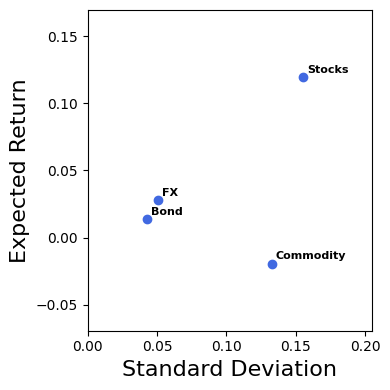

In [171]:
mu_l = avg_return_l.copy()
cov_l = returns_l.cov() * freq
std_l = np.sqrt(np.diag(cov_l))

plt.figure(figsize=(4, 4))
plt.scatter(std_l, mu_l, c='royalblue', label='Assets')
for symbol, s, m in zip(mu_l.index, std_l, mu_l):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std_l.max() + 0.05)
plt.ylim(mu_l.min() - 0.05, mu_l.max() + 0.05)
plt.tight_layout()
plt.savefig('Asset Allocation_Individual Assets.png', dpi=144, transparent=True)
plt.show()

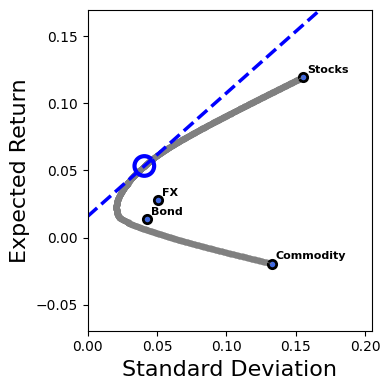

In [172]:
mu_targets_l = np.linspace(mu_l.min(), mu_l.max(), 1000)

portfolio_weights_l = [mvp_weight(mu_l, cov_l, target) for target in mu_targets_l]
portfolio_mu_l = [w @ mu_l for w in portfolio_weights_l]
portfolio_std_l = [np.sqrt(w @ cov_l @ w) for w in portfolio_weights_l]

# # GMVP
# gmvp = gmvp_weight(mu, cov)
# gmvp_mu = gmvp @ mu
# gmvp_std = np.sqrt(gmvp @ cov @ gmvp)

sharpe_ratios_l = (np.array(portfolio_mu_l) - rf) / np.array(portfolio_std_l)
max_sharpe_index_l = sharpe_ratios_l.argmax()
tangency_return_l = portfolio_mu_l[max_sharpe_index_l]
tangency_risk_l = portfolio_std_l[max_sharpe_index_l]

cal_x_l = np.linspace(0, max(portfolio_std_l), 1000)
cal_x_l = np.linspace(0, 1, 1000)
cal_y_l = rf + sharpe_ratios_l[max_sharpe_index_l] * cal_x_l

plt.figure(figsize=(4, 4))

plt.scatter(portfolio_std_l, portfolio_mu_l, c='gray', label='Efficient Frontier', s=10)
plt.plot(portfolio_std_l, portfolio_mu_l, color='gray', linewidth=0.5)

# plt.scatter(gmvp_std, gmvp_mu, c='white', s=600, marker='*', label='GMVP', edgecolors='k', linewidth=3)

plt.scatter(std_l, mu_l, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)

plt.plot(cal_x_l, cal_y_l, color='b', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')

plt.scatter(tangency_risk_l, tangency_return_l, facecolors='none', s=200, marker='o', label='Tangency Portfolio', edgecolors='b', linewidth=3)

for symbol, s, m in zip(mu_l.index, std_l, mu_l):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std_l.max() + 0.05)
plt.ylim(mu_l.min() - 0.05, mu_l.max() + 0.05)
plt.tight_layout()
plt.show()

In [173]:
tangency_weight_l = tangency_portfolio(mu_l, cov_l, rf).round(4)
tangency_weight_l = np.insert(tangency_weight_l, 3, np.nan)
tangency_weights.loc['Excluding CC'] = tangency_weight_l

display(tangency_weights)

,Avg,Std,Sharpe,Crypto,Stocks,Commodity,FX,Bond
Including CC,0.0822,0.0539,1.2325,0.0474,0.2422,0.0,0.6334,0.0770
Excluding CC,0.0533,0.0410,0.9191,NaN,0.2881,0.0,0.6448,0.0671


### Merge

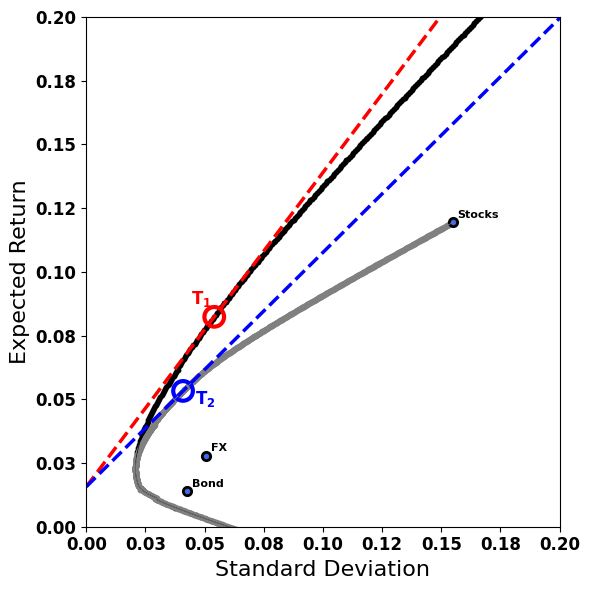

In [184]:
plt.figure(figsize=(6, 6))

plt.scatter(portfolio_std, portfolio_mu, c='k', label='Efficient Frontier', s=10)
plt.plot(portfolio_std, portfolio_mu, color='k', linewidth=0.5)

plt.scatter(portfolio_std_l, portfolio_mu_l, c='gray', label='Efficient Frontier', s=10)
plt.plot(portfolio_std_l, portfolio_mu_l, color='gray', linewidth=0.5)

plt.scatter(std, mu, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)

plt.plot(cal_x, cal_y, color='r', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')
plt.plot(cal_x_l, cal_y_l, color='b', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')

plt.scatter(tangency_risk, tangency_return, facecolors='none', s=200, marker='o', label='Tangency Portfolio', edgecolors='r', linewidth=3)
plt.scatter(tangency_risk_l, tangency_return_l, facecolors='none', s=200, marker='o', label='Tangency Portfolio', edgecolors='b', linewidth=3)

plt.text(tangency_risk - 0.01, tangency_return + 0.005, r'$\mathbf{T_1}$', color='r', fontsize=12, fontweight='bold')
plt.text(tangency_risk_l + 0.005, tangency_return_l - 0.005, r'$\mathbf{T_2}$', color='b', fontsize=12, fontweight='bold')

for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xticks(fontsize=12, fontweight='heavy')
plt.yticks(fontsize=12, fontweight='heavy')
plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
# plt.xlim(0, max(tangency_risk, tangency_risk_l, std_l.max()) + 0.01)
# plt.ylim(mu.min() - 0.01, max(tangency_return, tangency_return_l) + 0.05)
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.xlim(0, 0.20)
plt.ylim(0, 0.20)
plt.tight_layout()
plt.savefig('Asset Allocation.png', dpi=144, transparent=True)
plt.show()

## Correlation Between Traditional Assets and Cryptos

In [175]:
crypto_tickers = ['BTC-USD', 'ETH-USD', 'DOGE-USD']
stock_tickers = ['^GSPC', '000001.SS', '^N225', '^STOXX50E', '^FTSE']
commodity_tickers = ['GC=F', 'SI=F', 'HG=F', 'CL=F', 'PL=F']
fx_tickers = ['EUR=X', 'JPY=X', 'CNY=X']
bond_tickers = ['^TNX']

all_tickers = crypto_tickers + stock_tickers + commodity_tickers + fx_tickers + bond_tickers

asset_classes = {
    'Crypto': crypto_tickers,
    'Stocks': stock_tickers,
    'Commodity': commodity_tickers,
    'FX': fx_tickers,
    'Bond': bond_tickers
}

start_date = data.index[0]
end_date = '2025-01-01'

In [176]:
data_2 = yf.download(all_tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
data_2.index = pd.to_datetime(data_2.index)
data_2 = data_2.interpolate(method='time', axis=0)
data_2 = data_2.dropna()
data_2 = data_2.where(data_2 > 0, 1e-10)
data_2 = data_2[all_tickers]

[*********************100%%**********************]  17 of 17 completed


In [177]:
rename = {
    'BTC-USD': 'BTC',
    'ETH-USD': 'ETH',
    'DOGE-USD': 'DOGE',
    '^GSPC': 'SP500',
    '000001.SS': 'SSE',
    '^N225': 'Nikkei225',
    '^STOXX50E': 'EUStoxx50',
    '^FTSE': 'FTSE100',
    'GC=F': 'Gold',
    'SI=F': 'Silver',
    'HG=F': 'Copper',
    'CL=F': 'CrudeOil',
    'PL=F': 'Platinum',
    'EUR=X': 'EUR',
    'JPY=X': 'JPY',
    'CNY=X': 'CNY',
    '^TNX': 'US10Y'
}
data_2.rename(columns=rename, inplace=True)

In [178]:
returns_2 = np.log(data_2 / data_2.shift(1)).dropna()

cumulative_returns_2 = np.exp(returns_2.cumsum())
cumulative_returns_2.iloc[0] = 1

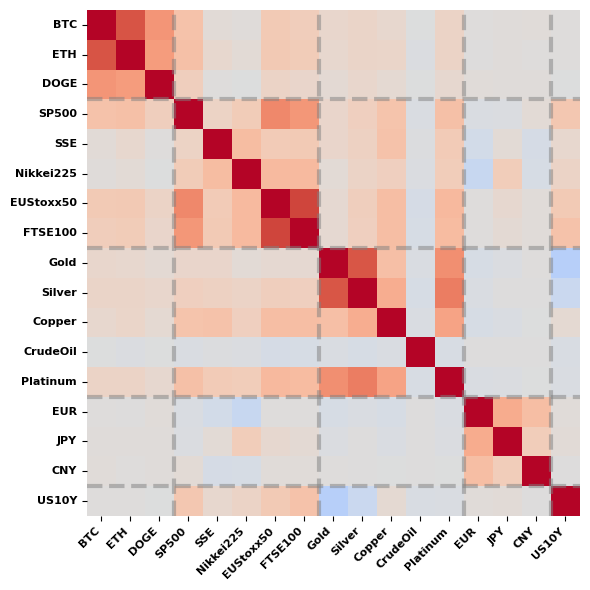

In [179]:
corr_matrix_all = returns_2.corr()

boundaries = []
start = 0
for category, tickers in asset_classes.items():
    end = start + len(tickers)
    boundaries.append((start, end))
    start = end

plt.figure(figsize=(6, 6))
sns.heatmap(
    corr_matrix_all,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    cbar=False,
    annot=False
)

for start, end in boundaries[:-1]:
    plt.axhline(y=end, color='gray', linewidth=3, linestyle='--', alpha=0.5)
    plt.axvline(x=end, color='gray', linewidth=3, linestyle='--', alpha=0.5)

plt.xticks(fontsize=8, fontweight='heavy', rotation=45, ha='right')
plt.yticks(fontsize=8, fontweight='heavy')

plt.tight_layout()
plt.savefig('Ind Corr Matrix.png', dpi=144, transparent=True)
plt.show()